# Clustering Comparison Analysis

We run a clustering model on some subset of the data and measure the similarity of the produced clusterings.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gp
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Read in data
data = pd.read_csv('../data/features/merged.csv')

## Create training data

In [3]:
# From here on out, we'll use a separate variable "training_data" for filtered data. 
# It's good not to overwrite the original 'data' variable
# in case we want to recover the filtered columns later.
training_data = data.copy()

### ... by filtering columns

In [4]:
# [ REPLACE THIS CODE TO DROP COLUMNS IF NECESSARY ]

# demo_columns = ['COMPLAINTS_BLACK','COMPLAINTS_HISPANIC','COMPLAINTS_WHITE','ISR_BLACK','ISR_WHITE','ISR_HISPANIC','UOF_HISPANIC','UOF_BLACK','UOF_WHITE','CENSUS_WHITE','CENSUS_BLACK','CENSUS_HISPANIC','CENSUS_MEDIAN INCOME', 'CENSUS_TOTAL POP']
# training_data = training_data.drop(demo_columns, axis=1)

# Drop all demographics
remove_cols = ['BLACK', 'WHITE', 'HISPANIC', 'CENSUS']
for dem in remove_cols:
    cols = [c for c in training_data.columns if dem in c]
    training_data.drop(cols, axis=1, inplace=True)
training_data.columns

Index(['BEAT', 'YEAR', 'COMPLAINTS_POLICE_SHOOTING', 'COMPLAINTS_TOTAL',
       'CRIME_TOTAL', 'CRIME_ARREST', 'CRIME_DOMESTIC', 'ISR_TOTAL_STOPS',
       'ISR_SEARCH', 'ISR_ARREST', 'UOF_TOTAL_COUNT', 'UOF_POLICE_W_WEAPON',
       'UOF_POLICE_WO_WEAPON'],
      dtype='object')

### .. by aggregating rows

For model selection, since we're eventually clustering by beat, we'll aggregate by summing all years together.


In [5]:
# [ REPLACE THIS CODE TO DROP ROWS IF NECESSARY ]

training_data = training_data.drop('YEAR',axis=1).groupby(by='BEAT').agg(np.sum).reset_index(drop=True)
training_data.head(2)

,COMPLAINTS_POLICE_SHOOTING,COMPLAINTS_TOTAL,CRIME_TOTAL,CRIME_ARREST,CRIME_DOMESTIC,ISR_TOTAL_STOPS,ISR_SEARCH,ISR_ARREST,UOF_TOTAL_COUNT,UOF_POLICE_W_WEAPON,UOF_POLICE_WO_WEAPON
0,0.0,25,8926,2217,196,2501,217,193.0,102,10,34
1,0.0,9,6570,1074,89,968,82,80.0,64,4,23


## Preprocess / Transform Data

In [6]:
from sklearn.preprocessing import StandardScaler
# Normalize columns
scaler = StandardScaler()
scaled_training_data = pd.DataFrame(scaler.fit_transform(training_data),\
    columns=training_data.columns)

In [7]:
# Do PCA
from util_clustering import generate_pca_data
N_TOP_PCA_COMPONENTS = 6 # See Model Selection.ipynb for why we chose this number.
pca_training_data, pca = generate_pca_data(scaled_training_data, N_TOP_PCA_COMPONENTS)

## Setup Best Model & Hyperparameters

In [8]:
from sklearn.cluster import KMeans

PARAM_N_CLUSTERS = 7 # See Model Selection.ipynb for why we chose this number.
cluster_model_params = {'n_clusters':PARAM_N_CLUSTERS}
cluster_model = KMeans()
cluster_model.set_params(**cluster_model_params)

KMeans(n_clusters=7)

## Run the model

In [9]:
cluster_labels = cluster_model.fit_predict(pca_training_data)
clustered_data = pd.concat([pca_training_data, pd.Series(cluster_labels, name='Cluster')], axis=1)

In [10]:
clustered_data.head()

,PC1,PC2,PC3,PC4,PC5,PC6,Cluster
0,2.154153,-0.556139,1.204775,-1.169982,2.916138,-0.345154,1
1,-0.712959,-0.397213,0.825376,-0.792141,2.122832,-0.394202,2
2,-0.662858,-0.397982,0.398048,0.343189,1.169731,-0.530594,2
3,-0.783367,-0.285063,0.855373,0.000778,1.045543,-0.769667,2
4,-2.824287,0.650939,0.038874,0.125945,0.573302,-0.183643,0


# Summarize Clustering

## Size of the clusters

Text(0, 0.5, 'Count of beats')

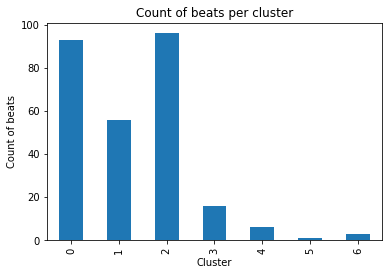

In [11]:
clustered_data['Cluster'].value_counts().sort_index().plot.bar()
plt.title('Count of beats per cluster')
plt.xlabel('Cluster')
plt.ylabel('Count of beats')

## Characteristics of the clusters

In [12]:
# Merge in all data
cluster_training_data = clustered_data.merge(training_data, left_index=True, right_index=True)

<AxesSubplot:xlabel='Cluster'>

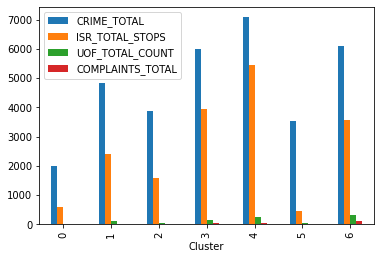

In [13]:
# Plot main features by cluster
sum_cols = ['CRIME_TOTAL', 'ISR_TOTAL_STOPS', 'UOF_TOTAL_COUNT', 'COMPLAINTS_TOTAL']
cluster_training_data.groupby(['Cluster'])[sum_cols].mean().plot.bar()

# Compare Clusters

## Define functions

### Functions to run clustering

In [14]:
def create_training_data(data, remove_cols, year):
    # Create training data
    training_data = data.copy()
    
    # filter columns
    for dem in remove_cols:
        cols = [c for c in training_data.columns if dem in c]
        training_data.drop(cols, axis=1, inplace=True)
        
    # filter by year
    training_data = training_data[training_data['YEAR']==year]
    training_data.drop('YEAR',axis=1)
    return training_data

In [15]:
def pre_process(training_data):
    # Normalize columns
    scaler = StandardScaler()
    scaled_training_data = pd.DataFrame(scaler.fit_transform(training_data),\
        columns=training_data.columns)
    
    # Do PCA
    N_TOP_PCA_COMPONENTS = 6 # See Model Selection.ipynb for why we chose this number.
    pca_training_data, pca = generate_pca_data(scaled_training_data, N_TOP_PCA_COMPONENTS)
    return pca_training_data

In [23]:
def setup_and_run_model(pca_training_data):
    # Setup model
    PARAM_N_CLUSTERS = 7 # See Model Selection.ipynb for why we chose this number.
    cluster_model_params = {'n_clusters':PARAM_N_CLUSTERS, 'random_state':0} # Set random state so we get same result
    cluster_model = KMeans()
    cluster_model.set_params(**cluster_model_params)
    
    # run model
    cluster_labels = cluster_model.fit_predict(pca_training_data)
    clustered_data = pd.concat([pca_training_data, pd.Series(cluster_labels, name='Cluster')], axis=1)
    return cluster_labels, clustered_data

In [17]:
def get_clusters(data, remove_cols, year):
    training_data = create_training_data(data, remove_cols, year)
    pca_training_data = pre_process(training_data)
    cluster_labels, clustered_data = setup_and_run_model(pca_training_data)
    return cluster_labels, clustered_data    

### Functions to compute similarity

In [18]:
def get_match_mat(labels):
    # create list of lists, where each sublist is list of bools if there is a match
    final_list = [] 
    for a in labels:
        col_list = []
        for b in labels:
            col_list.append(a==b)
        final_list.append(col_list)
    return np.array(final_list)

In [19]:
def get_pct_match(mat1, mat2, n):
    total_matches = np.sum(mat1 & mat2)
    # remove diagonal matches, and divide by two to only count a match once (matrix is symmetric)
    actual_matches = (total_matches - n) / 2
    max_matches = max(((np.sum(mat1) - n )/2), ((np.sum(mat2) - n) /2))
    percent_match = actual_matches / max_matches
    return percent_match

In [20]:
def get_sim_clusters(labels1, labels2):
    n = len(labels1)
    mat1 = get_match_mat(labels1)
    mat2 = get_match_mat(labels2)
    return get_pct_match(mat1, mat2, n)

## Compare across different years

In [21]:
years = [2016, 2017, 2018, 2019]

In [40]:
remove_cols = ['BLACK', 'WHITE', 'HISPANIC', 'CENSUS']

result_df = pd.DataFrame()
for year1 in years:
    _, clustered_data_1 = get_clusters(data, remove_cols, year1) # We are subsetting the labels later
    
    row_dict = {}

    for year2 in years:
        # Get clusters
        _, clustered_data_2 = get_clusters(data, remove_cols, year2)

        # Merge on beat and extract new cluster labesl only for those that match
        merge_clusters = clustered_data_1.merge(clustered_data_2, left_index=True, right_index=True)
        cluster_labels_1 = merge_clusters['Cluster_x']
        cluster_labels_2 = merge_clusters['Cluster_y']

        # Compare
        sim_score = get_sim_clusters(cluster_labels_1, cluster_labels_2)
        print(year1, year2, sim_score)
        row_dict[year2] = sim_score
    result_df = result_df.append(row_dict, ignore_index=True)


2016 2016 1.0
2016 2017 0.34057971014492755
2016 2018 0.3591401325359625
2016 2019 0.32852936618626993
2017 2016 0.34057971014492755
2017 2017 1.0
2017 2018 0.4048703849175177
2017 2019 0.3120567375886525
2018 2016 0.3591401325359625
2018 2017 0.4048703849175177
2018 2018 1.0
2018 2019 0.3588168740908356
2019 2016 0.32852936618626993
2019 2017 0.3120567375886525
2019 2018 0.3588168740908356
2019 2019 1.0


In [43]:
result_df.index = years
result_df

,2016,2017,2018,2019
2016,1.000000,0.340580,0.359140,0.328529
2017,0.340580,1.000000,0.404870,0.312057
2018,0.359140,0.404870,1.000000,0.358817
2019,0.328529,0.312057,0.358817,1.000000


<AxesSubplot:>

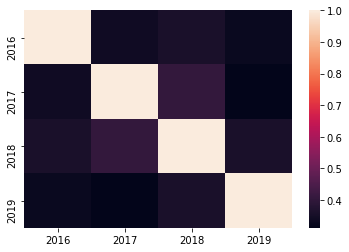

In [44]:
sns.heatmap(result_df)